In [ ]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#preprossing imports
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder,RobustScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#model development imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans , AgglomerativeClustering
from sklearn.decomposition import PCA # to reduce dimentions

from scipy.cluster.hierarchy import dendrogram, linkage

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
def load_data(file_path):
    return pd.read_excel(file_path)

def drop_null_values(data):
    return data.dropna()

def encode_class_labels(data):
    encoder = LabelEncoder()
    data['Class'] = encoder.fit_transform(data['Class'])
    return data

def scale_features(data):
    scaler = RobustScaler()
    features = data.columns.drop(['Class', 'Solidity', 'ShapeFactor2', 'ShapeFactor4', 'ShapeFactor3'])
    data[features] = scaler.fit_transform(data[features])
    for col in data:
      if data[col].min() < 0:
          data[col] += abs(data[col].min())
    return data

def combine_features(data):
    features = ['AspectRation', 'Eccentricity', 'Area', 'Perimeter', 'MajorAxisLength', 'EquivDiameter', 'ConvexArea', 'Compactness', 'ShapeFactor3']
    names = ['AR/ECC', 'AR/PE/MA/ED/CA', 'CO/SF3']
    combined_features_df = pd.DataFrame()

    for name, feature_group in zip(names, [features[:2], features[2:7], features[7:]]):
        combined_feature = data[feature_group].mean(axis=1)
        combined_features_df[name] = combined_feature

    data = pd.concat([data, pd.DataFrame(combined_features_df)], axis=1)
    data.drop(['AspectRation', 'Eccentricity', 'Area', 'Perimeter', 'MajorAxisLength', 'EquivDiameter', 'ConvexArea', 'Compactness', 'ShapeFactor3'], axis=1, inplace=True)
    return data

def remove_outliers(data):
    limiter = 5
    orf = ['ShapeFactor2','MajorAxisLength', 'Eccentricity','Solidity'] # outliers_removal_features , i plotted scatter to see weather outliers are present or not
    z_scores = (data[orf] - data[orf].mean()) / data[orf].std()
    return data[(z_scores.abs() < limiter).all(axis=1)]

def preprocess_data(file_path):
    data = load_data(file_path)
    data = drop_null_values(data)
    data = encode_class_labels(data)
    data = scale_features(data)
    data = remove_outliers(data)
    data = combine_features(data)

    #to shift class to end
    col = data.pop('Class')
    data['Class'] = col
    return data

def principle_component_analysis(X , n_components):
    pca = PCA(n_components=n_components)
    data = pca.fit_transform(X)

    # Add the absolute value of the minimum value to ensure all values are non-negative
    min_value = np.min(data)
    data += abs(min_value)

    return data

def split_data(data, test_size=0.2, random_state=42):
    n_components = 5
    X = data[data.columns.drop('Class')]
    # X = principle_component_analysis(X,n_components) # not required since data set is very small
    y = data['Class']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [ ]:
def logistic_regression(X_train, X_test, y_train, y_test):
    logistic_reg = LogisticRegression(max_iter=100, multi_class='multinomial', solver='lbfgs')
    logistic_reg.fit(X_train, y_train)
    y_pred = logistic_reg.predict(X_test)
    return y_pred, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

def knn(X_train, X_test, y_train, y_test, n_neighbors=15):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    return y_pred, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

def lda(X_train, X_test, y_train, y_test):
    clf = LDA()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

def qda(X_train, X_test, y_train, y_test):
    qlf = QDA()
    qlf.fit(X_train, y_train)
    y_pred = qlf.predict(X_test)
    return y_pred, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

def decision_trees(X_train, X_test, y_train, y_test):
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    return y_pred, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

def naive_bayes(X_train, X_test, y_train, y_test):
    naive_model = MNB()
    naive_model.fit(X_train, y_train)
    y_pred = naive_model.predict(X_test)
    return y_pred, accuracy_score(y_test, y_pred), classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred)

def kmeans_clustering(X_train, X_test, n_clusters=7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=33, n_init="auto").fit(X_train)
    kmeans_labels = kmeans.predict(X_test)
    silhouette = silhouette_score(X_test, kmeans_labels)
    return kmeans_labels, silhouette

def hierarchical_clustering(X, n_clusters=7):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    model = model.fit(X)
    test_labels = model.fit_predict(X)
    silhouette_hc = silhouette_score(X, test_labels)
    return test_labels, silhouette_hc

def evaluate(y_test, y_pred):
    return classification_report(y_test, y_pred), confusion_matrix(y_test, y_pred), confusion_matrix(y_test,y_pred)

In [ ]:
def main():
    # Data Preprocessing
    file_path = '/content/sample_data/Dry_Bean_Dataset.xlsx'
    data = preprocess_data(file_path)


    X_train, X_test, y_train, y_test = split_data(data)
    # print(data)

    # Model Development
    models = [logistic_regression, knn, lda, qda, decision_trees, naive_bayes]
    for model in models:
        y_pred, accuracy, report, confusion = model(X_train, X_test, y_train, y_test)
        print(f"Model: {model.__name__}")
        print("Accuracy:", accuracy)
        print("Classification Report:")
        print(report)
        print("Confusion Matrix:")
        print(confusion)
        print("\n")

    # Clustering
    kmeans_labels, silhouette_kmeans = kmeans_clustering(X_train, X_test)
    print("K-Means Clustering:")
    print("Silhouette Score:", silhouette_kmeans)
    print("\n")

    hc_labels, silhouette_hc = hierarchical_clustering(data[:-1])
    print("Hierarchical Clustering:")
    print("Silhouette Score:", silhouette_hc)
    print("\n")
    # evaluate_feature_relevance(X_test , hc_labels)
    print("\n")

    # Evaluation
    print("Evaluation:")
    for model in models:
        y_pred, _, _, _ = model(X_train, X_test, y_train, y_test)
        report, confusion, _ = evaluate(y_test, y_pred)
        print

    return data

data = main()

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: logistic_regression
Accuracy: 0.9124678190511217
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       270
           1       0.99      1.00      1.00       117
           2       0.92      0.92      0.92       319
           3       0.91      0.90      0.90       671
           4       0.95      0.95      0.95       377
           5       0.95      0.93      0.94       406
           6       0.85      0.89      0.87       559

    accuracy                           0.91      2719
   macro avg       0.93      0.92      0.92      2719
weighted avg       0.91      0.91      0.91      2719

Confusion Matrix:
[[233   1  19   0   3   2  12]
 [  0 117   0   0   0   0   0]
 [ 17   0 295   0   2   1   4]
 [  0   0   0 603   1  11  56]
 [  0   0   7   4 358   0   8]
 [  4   0   0  13   0 379  10]
 [  0   0   0  43  14   6 496]]


Model: knn
Accuracy: 0.917616770871644
Classification Report:
              precision 

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Model: decision_trees
Accuracy: 0.8940787054063994
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       270
           1       0.99      1.00      1.00       117
           2       0.91      0.87      0.89       319
           3       0.89      0.89      0.89       671
           4       0.90      0.96      0.93       377
           5       0.94      0.91      0.93       406
           6       0.83      0.84      0.84       559

    accuracy                           0.89      2719
   macro avg       0.91      0.91      0.91      2719
weighted avg       0.89      0.89      0.89      2719

Confusion Matrix:
[[237   1  15   0   4   5   8]
 [  0 117   0   0   0   0   0]
 [ 25   0 279   0  11   1   3]
 [  0   0   0 596   4   6  65]
 [  0   0   8   2 363   0   4]
 [  2   0   2  18   0 371  13]
 [  3   0   4  51  20  13 468]]


Model: naive_bayes
Accuracy: 0.7716072085325487
Classification Report:
              precis

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


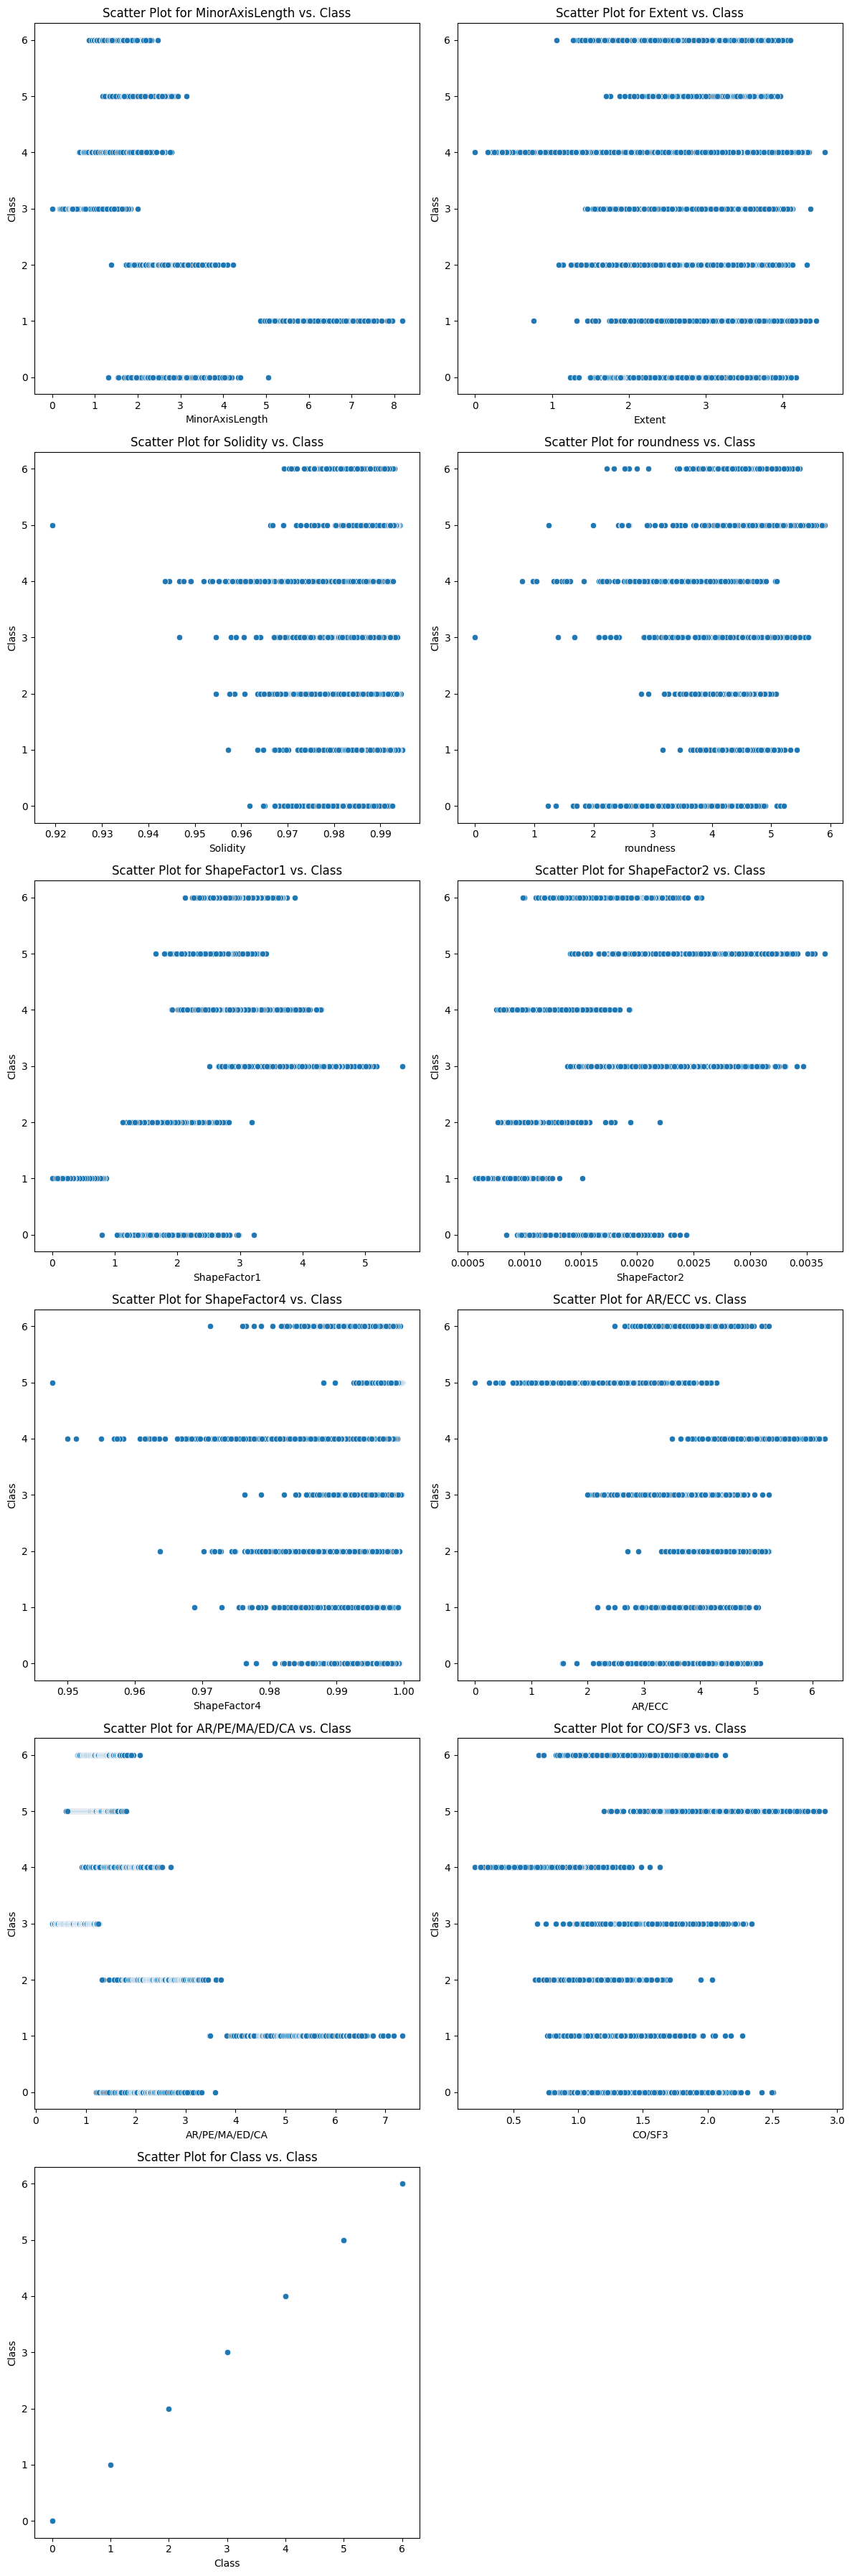

In [ ]:
def plot(X):
    features = X.columns
    num_features = len(features)
    rows = (num_features + 1) // 2
    cols = 2
    fig, axes = plt.subplots(rows, cols, figsize=(12, 6*rows))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        sns.scatterplot(x=feature, y='Class', data=X, ax=axes[i])
        axes[i].set_title(f'Scatter Plot for {feature} vs. Class')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Class')

    if num_features % 2 != 0:
        fig.delaxes(axes[-1])

    plt.tight_layout()
    plt.show()

plot(data)

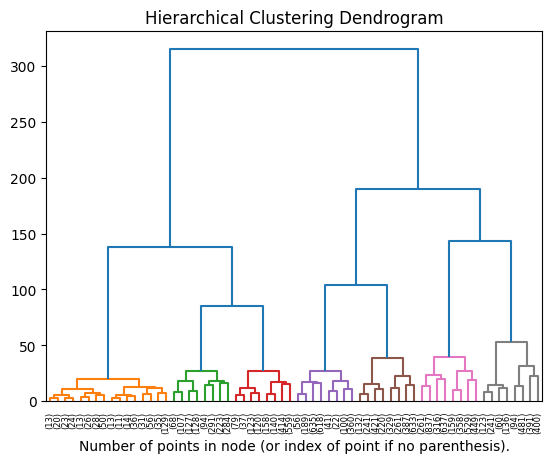

In [ ]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


X = data
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)


'''
#takes 1hr to execute
# After clustering, you can analyze the characteristics of clusters with respect to the original features
cluster_labels = model.labels_

# For each cluster, compute statistics for each feature
cluster_stats = []
for label in np.unique(cluster_labels):
    cluster_data = X[cluster_labels == label]
    cluster_mean = np.mean(cluster_data, axis=0)  # Mean of each feature in the cluster
    cluster_std = np.std(cluster_data, axis=0)    # Standard deviation of each feature in the cluster
    cluster_stats.append((label, cluster_mean, cluster_std))

# Print or visualize cluster statistics
for label, cluster_mean, cluster_std in cluster_stats:
    print(f"Cluster {label}:")
    for feature, mean, std in zip(X.columns, cluster_mean, cluster_std):
        print(f"  {feature}: Mean={mean}, Std={std}")

# Visualize feature distributions within clusters
for feature in X.columns:
    sns.boxplot(x=cluster_labels, y=X[feature])
    plt.title(f"Distribution of {feature} in Clusters")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.show()
'''

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=5 , color_threshold=55)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [ ]:
#cost heavy , for clustering
def evaluate_feature_relevance(silhouette_avg, data):
    feature_importance = []
    for feature_name in data.columns:
        feature_data = data[feature_name].values.reshape(-1, 1)  # Reshape to 2D array
        hc_labels, silhouette_hc = hierarchical_clustering(feature_data, feature_data)
        feature_importance.append((feature_name, silhouette_hc))

    print(feature_importance)

evaluate_feature_relevance(0.518, data)

[('MinorAxisLength', 0.5180661128054215), ('Extent', 0.5039373999538688), ('Solidity', 0.5229329116305274), ('roundness', 0.4787921703178318), ('ShapeFactor1', 0.5091863595985126), ('ShapeFactor2', 0.4768499268189141), ('ShapeFactor4', 0.5146187175630692), ('AR/ECC', 0.5179177453611307), ('AR/PE/MA/ED/CA', 0.5193765976839253), ('CO/SF3', 0.5159676721970078), ('Class', 1.0)]


above answers - [('MinorAxisLength', 0.5180661128054215), ('Extent', 0.5039373999538688), ('Solidity', 0.5229329116305274), ('roundness', 0.4787921703178318), ('ShapeFactor1', 0.5091863595985126), ('ShapeFactor2', 0.4768499268189141), ('ShapeFactor4', 0.5146187175630692), ('AR/ECC', 0.5179177453611307), ('AR/PE/MA/ED/CA', 0.5193765976839253), ('CO/SF3', 0.5159676721970078), ('Class', 1.0)]